In [1]:
import pandas as pd
from dataset_nuc import NucleiSegmentationDataset
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
from model_HoVer import HalfDualDecUNetPlusPlus
import torch.nn as nn
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import albumentations as A
import torch
from torch.utils import data
import numpy as np
from PIL import Image
import os
from he_randaugment import randaugment
import torchvision.transforms as transforms
import cv2
import ast
from scipy.ndimage import label


/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/abk9550/.local/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.2 (you have 1.4.18). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
def color_image_to_mask(color_image):
    color_to_class_map = {
    (255, 255, 255): 0,    # Background
    (200, 0, 0): 1,        # nuclei_tumor
    (255, 0, 255): 2,      # TILs (lymphocytes and plasma cells)
    (150, 200, 150): 3,    # Other cells (histiocytes, stromal cells, etc.)
    (0, 255, 0): 3,
    (51, 0, 51): 3,
    (0, 128, 128): 3,
    (204, 204, 51): 3,
    (102, 26, 51): 3,
    (51, 51, 51): 3
    }

    color_array = np.array(color_image)
    unique_colors = np.unique(color_array.reshape(-1, color_array.shape[2]), axis=0)

    # Erstelle eine leere Maske für die Klassenzuordnung
    mask = np.zeros((color_array.shape[0], color_array.shape[1]), dtype=np.uint8)

    for color in unique_colors:
        color_tuple = tuple(color)
        
        # Bestimme die Klasse, entweder durch explizite Zuordnung oder Standardklasse 3
        class_value = color_to_class_map.get(color_tuple, 3)
        
        is_color = np.all(color_array == color_tuple, axis=-1)
        
        if np.any(is_color):  # Nur wenn die Farbe im Bild vorkommt
            mask[is_color] = class_value
    return mask



def compute_hover_maps(maske):
        """
        Berechnet HoVer-Maps (horizontale und vertikale Karten) für eine Instanzsegmentierungsmaske.
    
        Args:
            maske (np.ndarray): 2D-Segmentierungsmaske (Höhe x Breite), bei der jede Klasse als Ganzzahl dargestellt wird.
    
        Returns:
            np.ndarray: Ein Array der Form (Höhe, Breite, 2),
                        wobei der erste Kanal die horizontalen und der zweite Kanal die vertikalen Vektoren enthält.
        """
        # Hintergrund ignorieren und Instanzen labeln
        gelabelte_maske, anzahl_instanz = label(maske > 0)  # Jede Instanz erhält eine eindeutige ID
        #print(f"Anzahl der Instanzen: {anzahl_instanz}")
    
        hoehe, breite = maske.shape
        hover_maps = np.zeros((hoehe, breite, 2), dtype=np.float32)
    
        for instanz_id in range(1, anzahl_instanz + 1):  # ID 0 ist Hintergrund
            # Maske für die aktuelle Instanz
            instanz_maske = (gelabelte_maske == instanz_id).astype(np.uint8)
    
            # Schwerpunkt der Instanz berechnen
            coords = np.argwhere(instanz_maske > 0)
            if len(coords) == 0:
                continue
    
            cx = np.mean(coords[:, 1])  # Durchschnitt der x-Koordinaten
            cy = np.mean(coords[:, 0])  # Durchschnitt der y-Koordinaten
    
            # Maximaldistanz für Normierung berechnen
            max_dist = np.max(np.sqrt((coords[:, 1] - cx)**2 + (coords[:, 0] - cy)**2)) + 1e-8
    
            # Berechne horizontale und vertikale Distanzen für jedes Pixel in der Instanz
            for y, x in coords:
                dx = x - cx
                dy = y - cy
                hover_maps[y, x, 0] = dx / max_dist  # Horizontal
                hover_maps[y, x, 1] = dy / max_dist  # Vertikal
    
        return hover_maps


Processing ROIs:   0%|                                    | 0/4 [00:00<?, ?it/s]

../dataset/nuclei/training_set_metastatic_roi_014.png


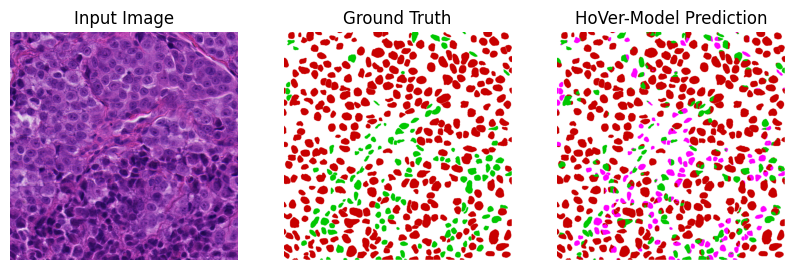

Processing ROIs:  25%|███████                     | 1/4 [00:03<00:09,  3.30s/it]

../dataset/nuclei/training_set_primary_roi_026.png


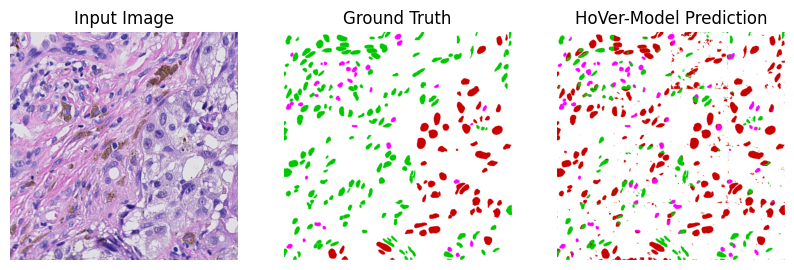

Processing ROIs:  50%|██████████████              | 2/4 [00:05<00:05,  2.91s/it]

../dataset/nuclei/training_set_primary_roi_027.png


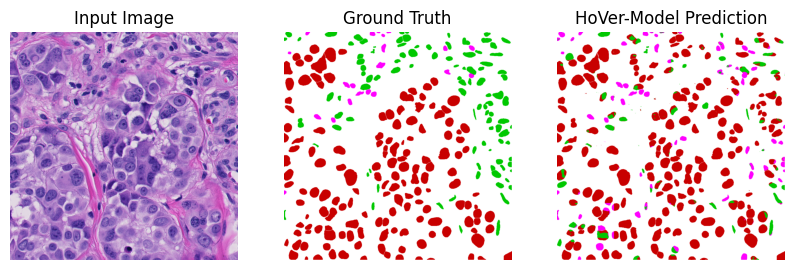

Processing ROIs:  75%|█████████████████████       | 3/4 [00:08<00:02,  2.91s/it]

../dataset/nuclei/training_set_metastatic_roi_081.png


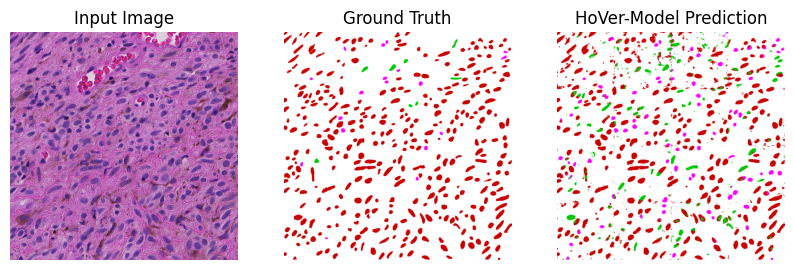

Processing ROIs: 100%|████████████████████████████| 4/4 [00:11<00:00,  2.91s/it]


In [16]:
import os
import numpy as np
import cv2
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

# Constants
num_classes = 4
patch_size = 256
class_colors = [
    (255, 255, 255),  # Background
    (200, 0, 0),      # nuclei_tumor
    (255, 0, 255),    # nuclei_lymphocyte
    (0, 200, 0)       # Other cells
]


def preprocess(image_path, ground_truth):
    """Preprocess image for Extended Input and Dice models."""
    image = Image.open(image_path).convert('RGB')
    image = np.array(image)
    normalize = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    rgb_image = normalize(image).unsqueeze(0).cuda()  # Add batch dimension

    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    gray_image = torch.tensor(gray_image, dtype=torch.float32) / 255.0
    gray_image = gray_image.unsqueeze(0) 

    hoVerMaps = compute_hover_maps(ground_truth)
    hoVerMaps = torch.tensor(hoVerMaps, dtype=torch.float32).permute(2, 0, 1)  # (2, H, B)
    rgb_image = rgb_image.squeeze(0) 
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Stelle sicher, dass alle Tensoren auf die GPU verschoben werden
    hoVerMaps = hoVerMaps.to(device)  
    rgb_image = rgb_image.to(device)
    gray_image = gray_image.to(device)
    image = torch.cat((rgb_image, hoVerMaps, gray_image), dim=0)  # (5, H, B)
    return  image.unsqueeze(0)

num_classes = 4



def apply_color_mapping(mask):
    """Map class values in the mask to RGB colors."""
    
    class_colors = [
    (255, 255, 255),  # Background
    (200, 0, 0),      # nuclei_tumor
    (255, 0, 255),    # nuclei_lymphocyte
    (0, 200, 0)   # Other cells
    ]
    mask_rgb = np.zeros((*mask.shape, 3), dtype=np.uint8)
    for k, color in enumerate(class_colors):
        mask_rgb[mask == k] = color
    return mask_rgb

def process_patches(model, image, patch_size, num_classes):
    """Perform patch-wise inference on the image."""
    _, _, h, w = image.shape
    full_pred = np.zeros((h, w, num_classes), dtype=np.float32)

    # Loop through the image in patches
    for y in range(0, h, patch_size):
        for x in range(0, w, patch_size):
            patch = image[:, :, y:y + patch_size, x:x + patch_size]

            # Pad patch if it exceeds boundaries
            pad_h = patch_size - patch.shape[2] if patch.shape[2] < patch_size else 0
            pad_w = patch_size - patch.shape[3] if patch.shape[3] < patch_size else 0
            if pad_h > 0 or pad_w > 0:
                patch = nn.functional.pad(patch, (0, pad_w, 0, pad_h), mode='constant', value=0)

            with torch.no_grad():
                output = model(patch)
            pred_patch = output.squeeze(0).cpu().numpy()  # Shape: (num_classes, H, W)

            # Transpose pred_patch to (H, W, num_classes)
            pred_patch = np.transpose(pred_patch, (1, 2, 0))

            # Add prediction to full image
            full_pred[y:y + patch_size, x:x + patch_size, :] += pred_patch[:patch.shape[2], :patch.shape[3], :]

    # Convert logits to class predictions
    full_pred = np.argmax(full_pred, axis=-1)
    return full_pred

def visualize_predictions(models, rois, base_path, g_path):
    """Visualize predictions from multiple models."""
    
    for roi in tqdm(rois, desc="Processing ROIs"):
        image_path = os.path.join(base_path, roi + ".tif")
        ground_truth_path = os.path.join(str(g_path), str(roi) + ".png")
        print(ground_truth_path)

        ground_truth = Image.open(ground_truth_path).convert('RGB')  # Load as RGB
        ground_truth = color_image_to_mask(ground_truth)  # Convert to class mask   
        ground_truth_rgb = apply_color_mapping(ground_truth)
        
        # Process predictions for each model
        predictions = {}
        for model_name, model in models.items():

            image = preprocess(image_path, ground_truth)
            predictions[model_name] = process_patches(model, image, patch_size, num_classes)

        # Map masks to RGB for visualization
      
        pred_rgb = {k: apply_color_mapping(v) for k, v in predictions.items()}

        # Plot input image, ground truth, and predictions
        input_image = np.array(Image.open(image_path))  # Reload for display
        fig, axes = plt.subplots(1, len(models) + 2, figsize=(10, 5))
        axes[0].imshow(input_image)
        axes[0].set_title("Input Image")
        axes[0].axis("off")

        axes[1].imshow(ground_truth_rgb)
        axes[1].set_title("Ground Truth")
        axes[1].axis("off")

        for idx, (model_name, pred) in enumerate(pred_rgb.items(), start=2):
            axes[idx].imshow(pred)
            axes[idx].set_title(f"{model_name} Prediction")
            axes[idx].axis("off")

        plt.show()

# Load models
models = {
    "HoVer-Model": nn.Sequential(HalfDualDecUNetPlusPlus(num_classes=4,in_channel=6), nn.Sigmoid()).cuda(),
}

# Load weights for each model
models["HoVer-Model"][0].load_state_dict(torch.load(r"../Hover/logs/HoVerUnet2/best_f1.pt"))

# ROIs and paths
rois = [
    "training_set_metastatic_roi_014",
    "training_set_primary_roi_026",
    "training_set_primary_roi_027",
    "training_set_metastatic_roi_081"
]
base_path = r"../dataset/01_training_dataset_tif_ROIs"
ground_truth_path = r"../dataset/nuclei"

# Visualize predictions
visualize_predictions(models, rois, base_path, ground_truth_path)


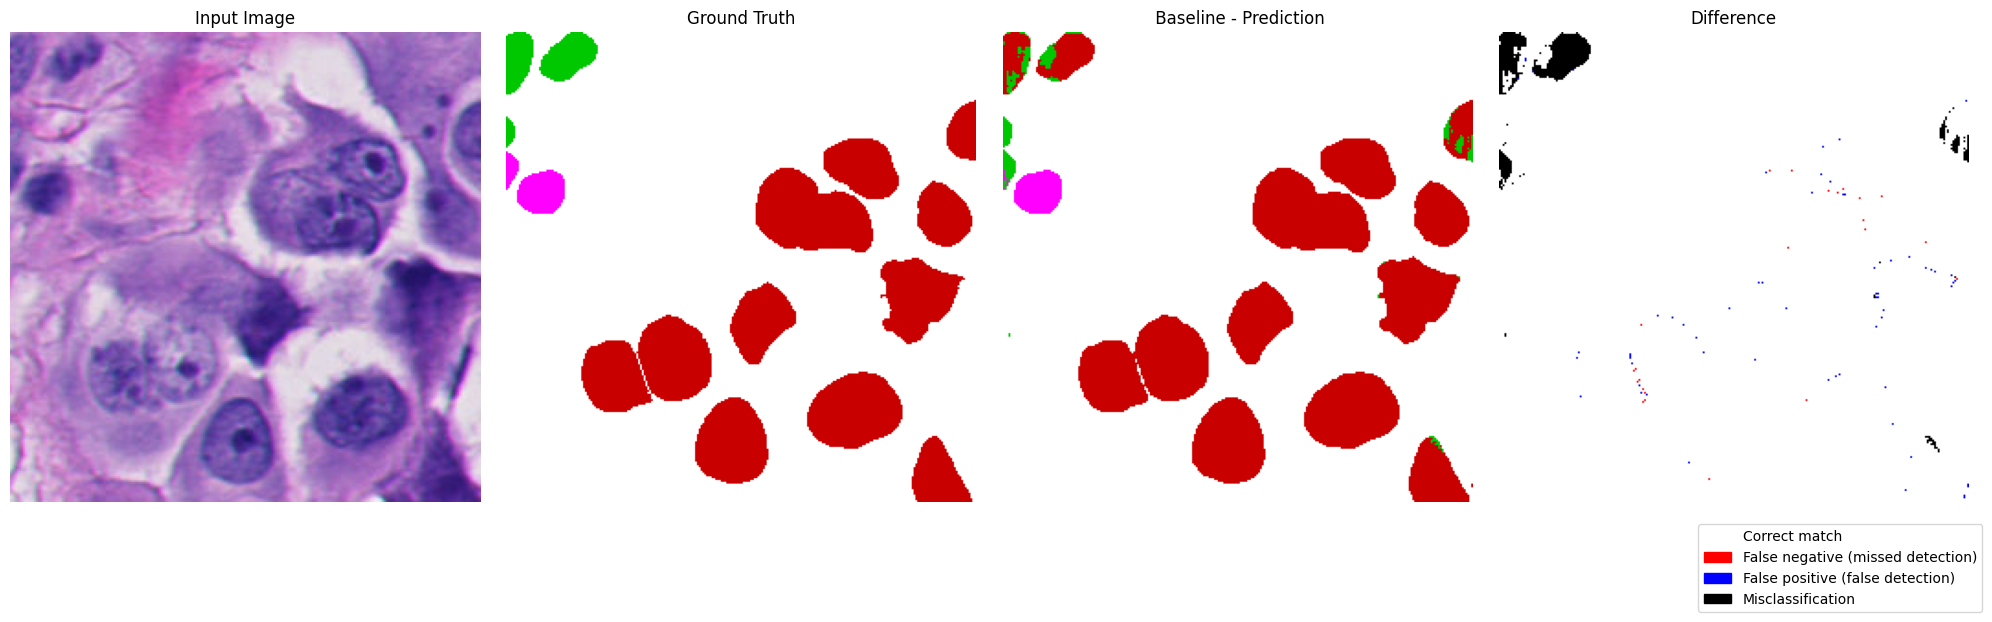

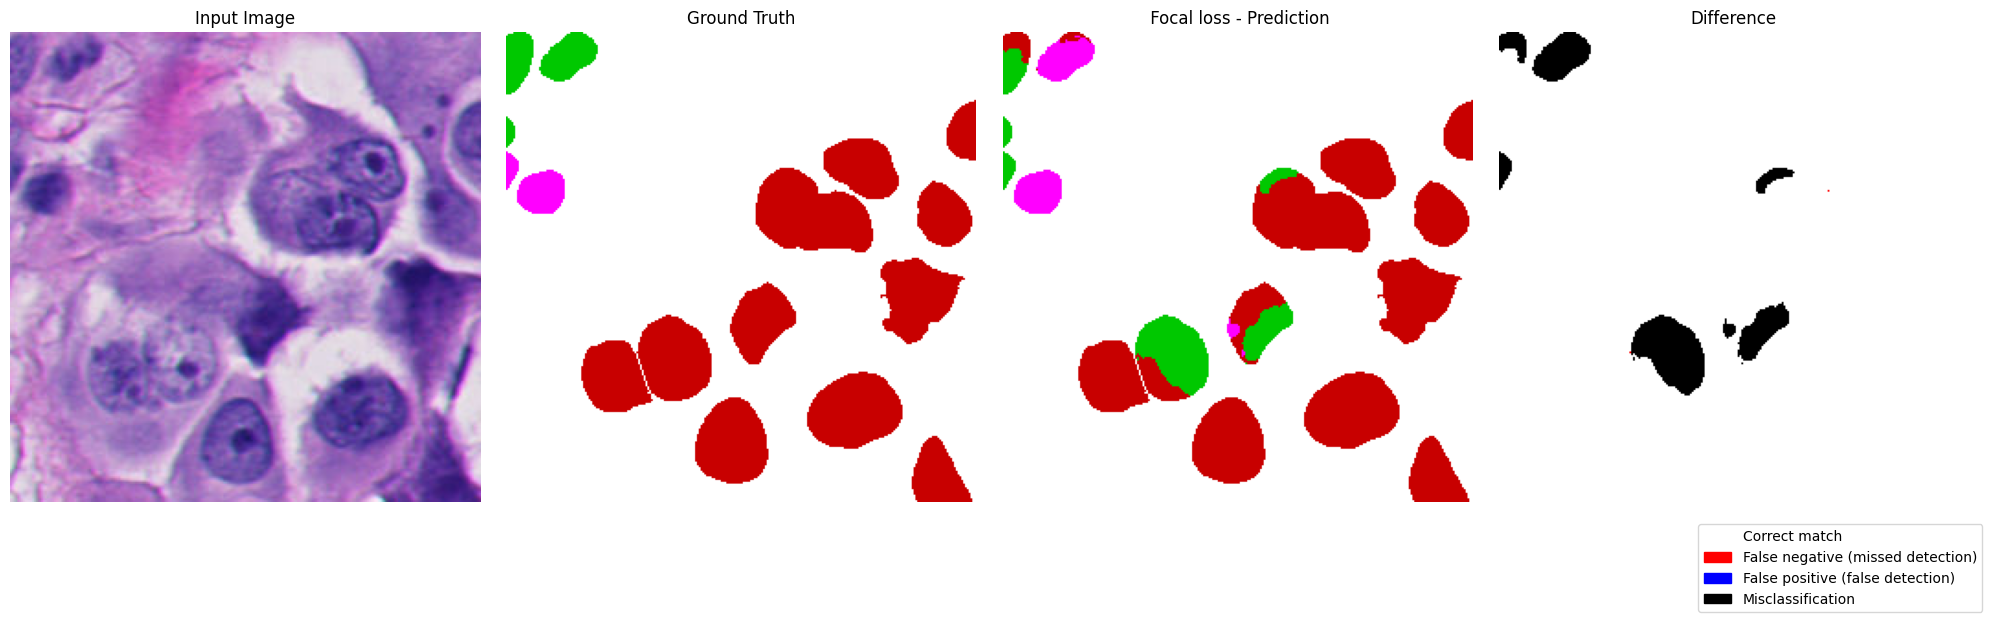

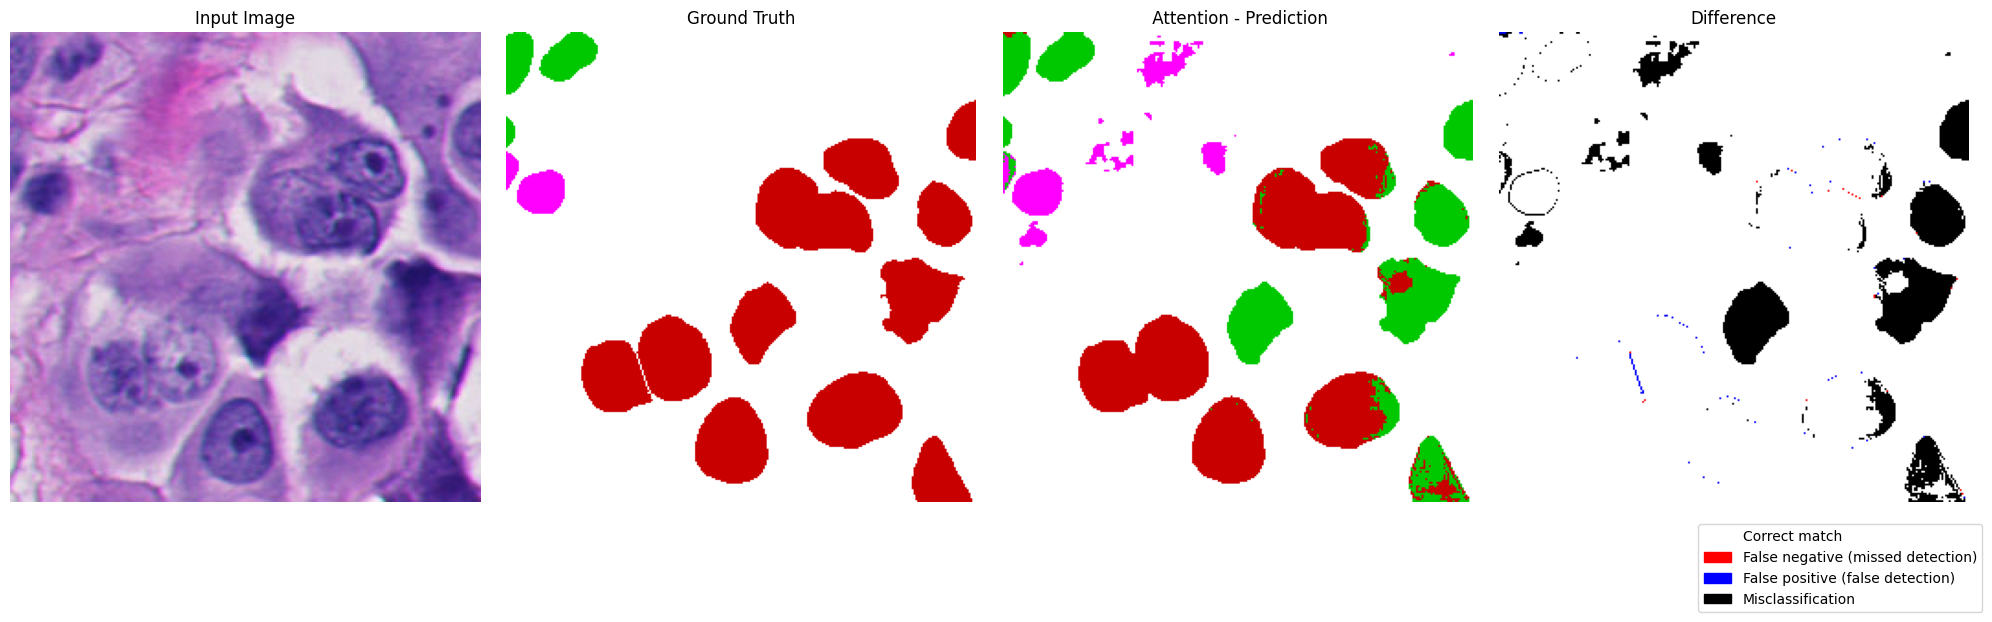

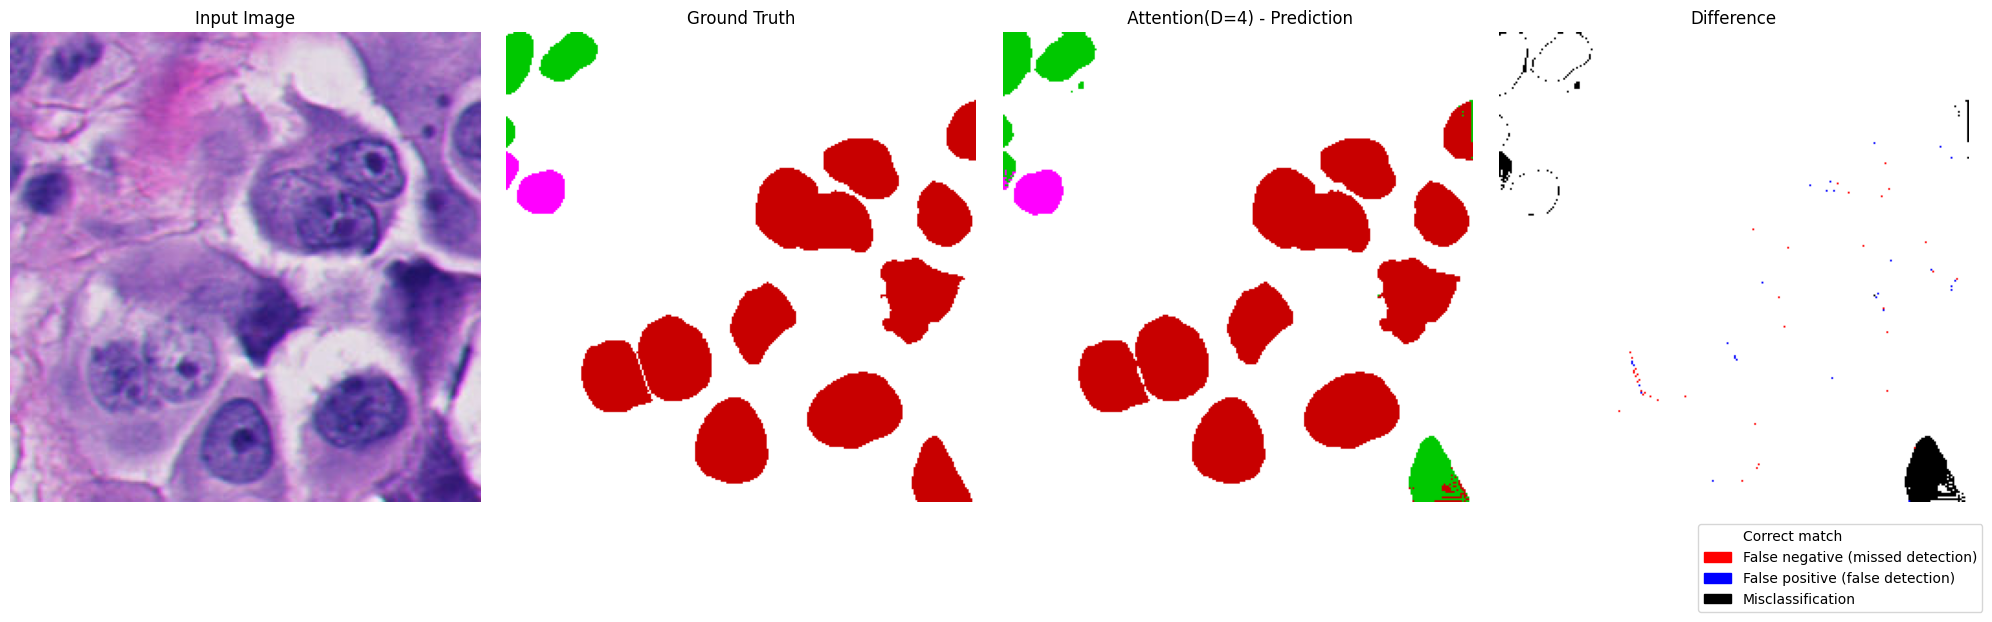

In [12]:
import os
import numpy as np
import cv2
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib.patches as mpatches

# Constants
num_classes = 4
patch_size = 256
class_colors = [
    (255, 255, 255),  # Background
    (200, 0, 0),      # nuclei_tumor
    (255, 0, 255),    # nuclei_lymphocyte
    (0, 200, 0)       # Other cells
]


def visualize_mask_difference(true_mask, pred_mask):
    """
    Visualisiert die Unterschiede zwischen der tatsächlichen und der vorhergesagten Maske in RGB:
    - Weiß: Korrekte Übereinstimmung
    - Rot: Falsch negative
    - Blau: Falsch positive
    
    Parameters:
    - true_mask_rgb: Numpy-Array der tatsächlichen Maske im RGB-Format
    - pred_mask_rgb: Numpy-Array der vorhergesagten Maske im RGB-Format
    """
    
    # RGB-Differenzmaske erstellen
    diff_mask = np.zeros((true_mask.shape[0], true_mask.shape[1], 3), dtype=np.uint8)

    # Bedingte Zuweisung mit Prüfung, ob Bedingung erfüllt ist
    if np.any((true_mask == 1) & (pred_mask == 0)):
        diff_mask[(true_mask == 1) & (pred_mask == 0)] = [255, 0, 0]  # Rot für falsch negative

    if np.any((true_mask == 0) & (pred_mask == 1)):
        diff_mask[(true_mask == 0) & (pred_mask == 1)] = [0, 0, 255]  # Blau für falsch positive

    # Übereinstimmende Pixel: Weiß anzeigen
    diff_mask[true_mask == pred_mask] = [255, 255, 255]  # Weiß für korrekt
    # Übereinstimmung beim Hintergrund ebenfalls weiß anzeigen
    diff_mask[(true_mask == 0) & (pred_mask == 0)] = [255, 255, 255]  # Weiß für Hintergrund-Übereinstimmung
    # Visualisierung anzeigen
    #plt.figure(figsize=(5, 5))
    #plt.title("Differenz zwischen True Mask und Pred Mask (RGB)")
    #plt.imshow(diff_mask)
    #plt.axis('off')  # Achsen ausblenden für bessere Darstellung

    # Legende erstellen
    #correct_patch = mpatches.Patch(color='white', label='Korrekte Übereinstimmung')
    #false_negative_patch = mpatches.Patch(color='red', label='Falsch negativ (nicht erkannt)')
    #false_positive_patch = mpatches.Patch(color='blue', label='Falsch positiv (erfunden)')
    
    # Legende zur Grafik hinzufügen
    #plt.legend(handles=[correct_patch, false_negative_patch, false_positive_patch],
    #           loc='upper right', bbox_to_anchor=(0.0, 0.0))
    
    #plt.show()

    return diff_mask


def calculate_iou(pred, true):
    """Calculate Intersection over Union (IoU) for each class and return the mean IoU."""
    iou_scores = []
    for class_idx in range(len(class_colors)):
        intersection = np.logical_and(pred == class_idx, true == class_idx).sum()
        union = np.logical_or(pred == class_idx, true == class_idx).sum()
        if union == 0:
            iou_scores.append(float('nan'))  # Ignore classes not present in the sample
        else:
            iou_scores.append(intersection / union)
    return np.nanmean(iou_scores)  # Compute mean IoU, ignoring NaNs


# Preprocessing functions


def preprocess(image_path, ground_truth):
    """Preprocess image for Extended Input and Dice models."""
    image = Image.open(image_path).convert('RGB')
    image = np.array(image)
    normalize = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    rgb_image = normalize(image).unsqueeze(0).cuda()  # Add batch dimension

    foreground_mask = (ground_truth != 0).astype(int)
    foreground_mask = torch.tensor(foreground_mask, dtype=torch.float32)
    foreground_mask = foreground_mask.unsqueeze(0).unsqueeze(0).cuda()
    image = torch.cat((rgb_image, foreground_mask), dim=1)  # Concatenation entlang der Channel-Dimension
    return image
    

def process_single_patch_path(model, image, num_classes):
    """Process a single patch from a given patch path."""

    full_pred = np.zeros((256, 256, num_classes), dtype=np.float32)
    
    with torch.no_grad():
        output = model(image)
    
    pred_patch = output.squeeze(0).cpu().numpy()  # Shape: (num_classes, H, W)
    
    # Transpose pred_patch to (H, W, num_classes)
    pred_patch = np.transpose(pred_patch, (1, 2, 0))
    
    # Convert logits to class predictions
    pred_patch = np.argmax(pred_patch, axis=-1)
    return pred_patch

def visualize_single_patch_path(models, patch_path, patch_mask_path, patch_size, num_classes):
    """Visualize input image, ground truth, prediction, and difference for each model."""
    # Load and preprocess the ground truth
    ground_truth = np.array(Image.open(patch_mask_path))  # Ground truth mask
    ground_truth = color_image_to_mask(Image.fromarray(ground_truth))  # Convert to class mask
    inp_img = np.array(Image.open(patch_path))  # Ground truth mask
    
    correct_patch = mpatches.Patch(color='white', label='Correct match')
    false_negative_patch = mpatches.Patch(color='red', label='False negative (missed detection)')
    false_positive_patch = mpatches.Patch(color='blue', label='False positive (false detection)')
    misclassification_patch = mpatches.Patch(color='black', label='Misclassification')

    for model_name, model in models.items():
        # Preprocess the image based on the model type
    
        image = preprocess(patch_path, ground_truth)
            
        # Generate the prediction
        prediction = process_single_patch_path(model, image, num_classes)
        
        # Calculate the difference
        difference = visualize_mask_difference(ground_truth, prediction)
        
        # Convert masks to RGB for visualization
        ground_truth_rgb = apply_color_mapping(ground_truth)
        prediction_rgb = apply_color_mapping(prediction)
        #difference_rgb = apply_color_mapping(difference)
        
        # Convert the preprocessed image to displayable format
        input_image = image.squeeze(0).permute(1, 2, 0).cpu().numpy()  # Convert to HWC format
        
        # Plot input image, ground truth, prediction, and difference
        fig, axes = plt.subplots(1, 4, figsize=(20, 5))

        axes[0].imshow(inp_img)
        axes[0].set_title(f"Input Image")
        axes[0].axis("off")

            
        axes[1].imshow(ground_truth_rgb)
        axes[1].set_title("Ground Truth")
        axes[1].axis("off")
        
        axes[2].imshow(prediction_rgb)
        axes[2].set_title(f" {model_name} - Prediction")
        axes[2].axis("off")
        
        axes[3].imshow(difference)
        axes[3].set_title("Difference")
        axes[3].axis("off")

        fig.legend(handles=[correct_patch, false_negative_patch, false_positive_patch, misclassification_patch], 
           loc='upper right', bbox_to_anchor=(1.0, 0.0))
        
        plt.tight_layout()
        plt.show()





# Load models
models = {
    "Baseline": nn.Sequential(HalfDualDecUNetPlusPlus(in_channel=4, att=False), nn.Sigmoid()).cuda(),
    "Focal loss": nn.Sequential(HalfDualDecUNetPlusPlus(in_channel=4, att=False), nn.Sigmoid()).cuda(),
    "Attention": nn.Sequential(HalfDualDecUNetPlusPlus(in_channel=4), nn.Sigmoid()).cuda(),
    "Attention(D=4)": nn.Sequential(HalfDualDecUNetPlusPlusD4(in_channel=4), nn.Sigmoid()).cuda(),
}

# Load weights for each model
models["Baseline"][0].load_state_dict(torch.load(r"../skripte/logs/M_Baseline_4C_F/best_f1.pt"))
models["Focal loss"][0].load_state_dict(torch.load(r"../skripte/logs/M_Focal_4C_F/best_f1.pt"))
models["Attention"][0].load_state_dict(torch.load(r"../skripte/logs/M_Attention/best_f1.pt"))
models["Attention(D=4)"][0].load_state_dict(torch.load(r"../skripte/logs/M_Attention_T4/best_f1.pt"))


# Define paths to patch and mask
#patch_path = "../dataset/patches/images/training_set_primary_roi_020_img_patch_192_768.png"
#patch_mask_path = "../dataset/patches/nuclei_mask/training_set_primary_roi_020_nuclei_patch_192_768.png"

patch_size = 256  
num_classes = 4  

p = "../dataset/patches/images/training_set_primary_roi_027_img_patch_384_192.png"
p_m = "../dataset/patches/nuclei_mask/training_set_primary_roi_027_nuclei_patch_384_192.png"

visualize_single_patch_path(models, p, p_m, patch_size, num_classes)

In [28]:
import os
import numpy as np
import cv2
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.patches as mpatches

# IoU-Berechnung
def calculate_iou(true_mask, pred_mask, num_classes):
    iou_scores = []
    for cls in range(num_classes):
        intersection = np.logical_and(true_mask == cls, pred_mask == cls).sum()
        union = np.logical_or(true_mask == cls, pred_mask == cls).sum()
        if union == 0:
            iou_scores.append(0.0)  # Kein IoU für diese Klasse
        else:
            iou_scores.append(intersection / union)
    return np.mean(iou_scores)

# Visualisierung der Masken mit Differenz
def visualize_and_save(image, true_mask, pred_mask, difference, iou, model_name, output_dir, patch_name):
    input_image = image.squeeze(0).permute(1, 2, 0).cpu().numpy()
    ground_truth_rgb = apply_color_mapping(true_mask)
    prediction_rgb = apply_color_mapping(pred_mask)

    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    axes[0].imshow(input_image)
    axes[0].set_title(f"{model_name} - Input Image")
    axes[0].axis("off")

    axes[1].imshow(ground_truth_rgb)
    axes[1].set_title("Ground Truth")
    axes[1].axis("off")

    axes[2].imshow(prediction_rgb)
    axes[2].set_title(f"Prediction (IoU: {iou:.2f})")
    axes[2].axis("off")

    axes[3].imshow(difference)
    axes[3].set_title("Difference")
    axes[3].axis("off")

    # Legende
    correct_patch = mpatches.Patch(color='white', label='Correct Match')
    false_negative_patch = mpatches.Patch(color='red', label='False Negative')
    false_positive_patch = mpatches.Patch(color='blue', label='False Positive')
    fig.legend(handles=[correct_patch, false_negative_patch, false_positive_patch],
               loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=3, fontsize='small')

    # Speichern der Visualisierung
    #os.makedirs(output_dir, exist_ok=True)
    #plt.savefig(os.path.join(output_dir, f"{patch_name}_{model_name}.png"), dpi=150, bbox_inches="tight")
    plt.close(fig)

# Hauptfunktion
def process_all_patches(csv_file, models, num_classes, output_dir):
    # CSV-Datei laden
    df = pd.read_csv(csv_file)
    results = []

    # Schleife über alle Patches
    for _, row in df.iterrows():
        patch_path = row['path']
        mask_path = row['nuclei_mask']
        patch_name = os.path.basename(patch_path).split('.')[0]

        # Ground Truth laden
        ground_truth = np.array(Image.open(mask_path))
        ground_truth = color_image_to_mask(Image.fromarray(ground_truth))  # Convert to class mask

        for model_name, model in models.items():
            # Bild vorverarbeiten
            if model_name == "Baseline":
                image = preprocess_baseline(patch_path)
            else:
                image = preprocess_extended_dice(patch_path)

            # Vorhersage generieren
            prediction = process_single_patch_path(model, image, num_classes)

            # Differenzmaske berechnen
            difference = visualize_mask_difference(ground_truth, prediction)

            # IoU berechnen
            iou = calculate_iou(ground_truth, prediction, num_classes)
            results.append((patch_name, model_name, iou))

            # Visualisierung speichern
            visualize_and_save(image, ground_truth, prediction, difference, iou, model_name, output_dir, patch_name)

    # Ergebnisse sortieren
    results = sorted(results, key=lambda x: x[2], reverse=True)

    # Beste 2 und schlechteste 2 Ergebnisse
    best_2 = results[:2]
    worst_2 = results[-2:]

    print("Top 2 Ergebnisse (IoU):")
    for patch_name, model_name, iou in best_2:
        print(f"{patch_name} - {model_name}: IoU = {iou:.2f}")

    print("\nSchlechteste 2 Ergebnisse (IoU):")
    for patch_name, model_name, iou in worst_2:
        print(f"{patch_name} - {model_name}: IoU = {iou:.2f}")

# Modelle laden
models = {
    "Baseline": nn.Sequential(HalfDualDecUNetPlusPlus(in_channel=3), nn.Sigmoid()).cuda(),
    "Extended": nn.Sequential(HalfDualDecUNetPlusPlus(in_channel=4), nn.Sigmoid()).cuda(),
    "DiceCE": nn.Sequential(HalfDualDecUNetPlusPlus(in_channel=4), nn.Sigmoid()).cuda(),
}
models["Baseline"][0].load_state_dict(torch.load(r"../skripte/logs/M_Baseline/best_f1.pt"))
models["DiceCE"][0].load_state_dict(torch.load(r"../skripte/logs/M_DiceCE/best_f1.pt"))
models["Extended"][0].load_state_dict(torch.load(r"../skripte/logs/M_Extend/best_f1.pt"))

# CSV-Datei und Ausgabeordner
csv_file = "dataset/val.csv"
output_dir = ""

# Alle Patches verarbeiten
process_all_patches(csv_file, models, num_classes, output_dir)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Top 2 Ergebnisse (IoU):
training_set_primary_roi_027_img_patch_0_384 - DiceCE: IoU = 0.84
training_set_primary_roi_027_img_patch_384_192 - Extended: IoU = 0.78

Schlechteste 2 Ergebnisse (IoU):
training_set_primary_roi_012_img_patch_0_0 - Extended: IoU = 0.19
training_set_primary_roi_012_img_patch_0_0 - DiceCE: IoU = 0.19


In [ ]:
training_set_primary_roi_027_img_patch_0_384 - DiceCE: IoU = 0.84
training_set_primary_roi_027_img_patch_384_192 - Extended: IoU = 0.78

Schlechteste 2 Ergebnisse (IoU):
training_set_primary_roi_012_img_patch_0_0 - Extended: IoU = 0.19
training_set_primary_roi_012_img_patch_0_0 - DiceCE: IoU = 0.19